# importing the dateset

In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


11411456/11490434 [============================>.] - ETA: 0s

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

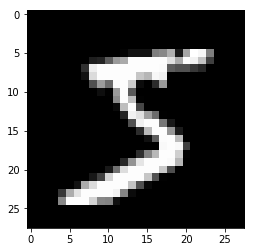

In [3]:
plt.imshow(x_train[0], cmap='gray')

### data pre processing

In [4]:
# store original train and test sets 

(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = (x_train, y_train), (x_test, y_test)

In [5]:
def preprocess(x):    
    x = x.reshape(-1, 1, 784) # 784=28*28
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [6]:
def depreprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

# creating the model

In [7]:
import keras as K
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Flatten
from keras.optimizers import Adam

ctx.integrate_with_keras()

### the generator 

In [8]:
generator = Sequential(name="generator")
generator.add(Dense(units=256, input_shape=(1, 128)))
generator.add(LeakyReLU(alpha=0.01))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.01))
generator.add(Dense(784))

generator.add(Activation("tanh"))

### the discriminator

In [9]:
discriminator = Sequential(name = "discriminator")
discriminator.add(Dense(units=512,input_shape=(1, 784)))
discriminator.add(LeakyReLU(alpha=0.01))
discriminator.add(Dense(265))
discriminator.add(LeakyReLU(alpha=0.01))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.01))
discriminator.add(Dense(1))
discriminator.add(Flatten())
discriminator.add(Activation('sigmoid'))

In [10]:
gan = Sequential([
    generator,
    discriminator
])

In [11]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [12]:
g_learning_rate = 0.01  # learning rate for the generator
d_learning_rate = 0.01   # learning rate for the discriminator

discriminator.compile(optimizer=Adam(lr=d_learning_rate,decay=1e-6), loss='binary_crossentropy')
gan.compile(optimizer=Adam(lr=g_learning_rate, decay=1e-6), loss='binary_crossentropy')

# Training

In [13]:
def make_samples(batch_size):
    return np.random.normal(size=(batch_size, 1, 128))

In [14]:
def zeros(batch_size):
    return np.zeros((batch_size,1))

def ones(batch_size):
    return np.ones((batch_size,1))

In [33]:
epochs = 50
batch_size = 128
m = x_train.shape[0]
eval_size = 16
smooth = 0.1


losses = []

for epoch in range(epochs):
    for i in range(m // batch_size):
        X_batch_real = x_train[i*batch_size:(i+1)*batch_size]
                
        # generate fake images from by the generator
        latent_samples = make_samples(batch_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, ones(batch_size) * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, zeros(batch_size))
        
        #train the generator via gan
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, ones(batch_size))
        
    # evaluate
    X_eval_real = x_test[np.random.choice(len(x_test), eval_size, replace=False)]

    latent_samples = make_samples(eval_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, ones(eval_size))
    d_loss += discriminator.test_on_batch(X_eval_fake, zeros(eval_size))
    # we want the fake to be realistic!
    g_loss  = gan.test_on_batch(latent_samples, ones(eval_size)) 
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        epoch+1, epochs, d_loss, g_loss))
    

Epoch:   1/50 Discriminator Loss: 1.2830 Generator Loss: 1.7510
Epoch:   2/50 Discriminator Loss: 0.4008 Generator Loss: 3.0940
Epoch:   3/50 Discriminator Loss: 0.4953 Generator Loss: 2.3277
Epoch:   4/50 Discriminator Loss: 0.7307 Generator Loss: 2.6453
Epoch:   5/50 Discriminator Loss: 0.5914 Generator Loss: 2.6369
Epoch:   6/50 Discriminator Loss: 0.7861 Generator Loss: 2.2398
Epoch:   7/50 Discriminator Loss: 0.4418 Generator Loss: 2.4533
Epoch:   8/50 Discriminator Loss: 0.5742 Generator Loss: 2.3006
Epoch:   9/50 Discriminator Loss: 0.5413 Generator Loss: 2.2178
Epoch:  10/50 Discriminator Loss: 0.7690 Generator Loss: 2.5287
Epoch:  11/50 Discriminator Loss: 0.8150 Generator Loss: 2.2773
Epoch:  12/50 Discriminator Loss: 0.6884 Generator Loss: 2.0132
Epoch:  13/50 Discriminator Loss: 0.6237 Generator Loss: 2.3607
Epoch:  14/50 Discriminator Loss: 0.6716 Generator Loss: 2.8052
Epoch:  15/50 Discriminator Loss: 0.4598 Generator Loss: 2.4050
Epoch:  16/50 Discriminator Loss: 0.8410

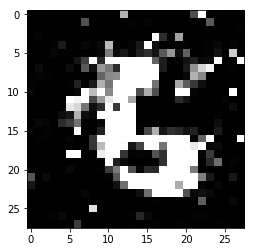

In [34]:
plt.imshow(depreprocess(generator.predict(make_samples(1))), cmap="gray")

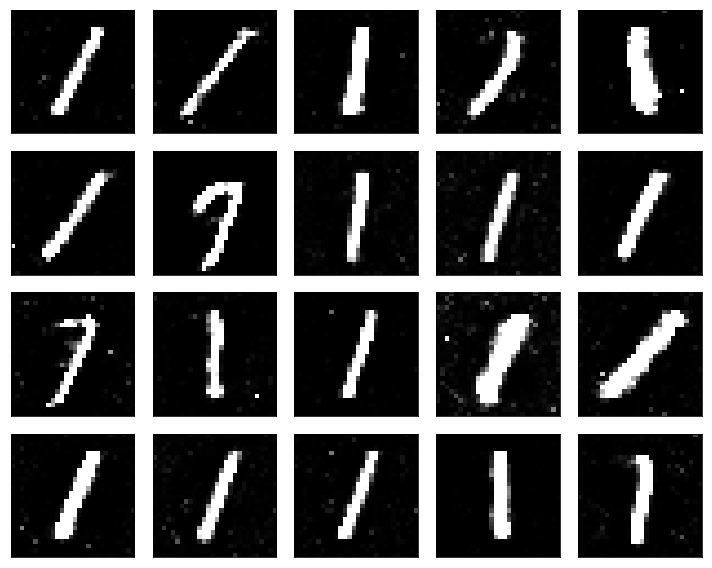

In [35]:
latent_samples = make_samples(20)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(20):
    img = depreprocess(generated_digits[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()